# 摄像头实时预测-三角板关键点检测

同济子豪兄 2023-5-12

## 进入mmpose目录

In [1]:
import os
os.chdir('mmpose')

## MMPose官方摄像头预测

In [ ]:
# RTMDet --> RTMPose
!python demo/topdown_demo_with_mmdet.py \
        data/rtmdet_tiny_triangle.py \
        checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth \
        data/rtmpose-s_triangle_8xb256-420e_coco-256x192.py \
        checkpoint/rtmpose_s_triangle_300-34bfaeb2_20230512.pth \
        --input webcam \
        --output-root outputs/G2_Video \
        --device cpu \
        --bbox-thr 0.6 \
        --kpt-thr 0.5 \
        --nms-thr 0.3 \
        --radius 16 \
        --thickness 3 \
        --draw-bbox \
        --draw-heatmap \
        --show-kpt-idx \
        --show 

Loads checkpoint by local backend from path: checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth
Loads checkpoint by local backend from path: checkpoint/rtmpose_s_triangle_300-34bfaeb2_20230512.pth
05/12 17:27:30 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.
/Users/tommy/opt/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/tommy/opt/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-d

## MMPose官方的Webcam API（按ESC键退出）

In [4]:
# 下载配置文件

# !rm -rf mmpose\apis\webcam\nodes\model_nodes\pose_estimator_node.py
# !wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/webcam/pose_estimator_node.py -P mmpose\apis\webcam\nodes\model_nodes
    
!rm -rf demo/webcam_cfg/triangle_estimation.py
!wget https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/webcam/triangle_estimation.py -P demo/webcam_cfg

--2023-05-12 17:33:23--  https://zihao-openmmlab.obs.myhuaweicloud.com/20220610-mmpose/triangle_dataset/webcam/triangle_estimation.py
正在解析主机 zihao-openmmlab.obs.myhuaweicloud.com (zihao-openmmlab.obs.myhuaweicloud.com)... 121.36.235.132
正在连接 zihao-openmmlab.obs.myhuaweicloud.com (zihao-openmmlab.obs.myhuaweicloud.com)|121.36.235.132|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：4074 (4.0K) [binary/octet-stream]
正在保存至: “demo/webcam_cfg/triangle_estimation.py”

triangle_estimation 100%[===================>]   3.98K  --.-KB/s  用时 0.006s    

2023-05-12 17:33:24 (660 KB/s) - 已保存 “demo/webcam_cfg/triangle_estimation.py” [4074/4074])



In [ ]:
# 命令行运行
!python demo/webcam_api_demo.py \
        --config demo/webcam_cfg/triangle_estimation.py \
        --cpu

demo/webcam_api_demo.py:56: DeprecationWarning: The Webcam API will be deprecated in future. 
  DeprecationWarning)
Loads checkpoint by local backend from path: checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth
05/12 17:33:29 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "node" registry tree. As a workaround, the current "node" registry in "mmpose" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.
Loads checkpoint by local backend from path: checkpoint/rtmpose_s_triangle_300-34bfaeb2_20230512.pth
/Users/tommy/opt/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tommy/opt/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars

## 导入工具包

In [2]:
import time

import cv2
import numpy as np

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms

from mmdet.apis import inference_detector, init_detector

/Users/tommy/opt/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


## 准备好模型文件

In [4]:
## 目标检测模型

# data/rtmdet_tiny_triangle.py
# checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth

## 关键点检测模型

# data/rtmpose-s_triangle_8xb256-420e_coco-256x192.py
# checkpoint/rtmpose_s_triangle_300-34bfaeb2_20230512.pth

## 构建目标检测模型

In [5]:
# RTMDet 三角板检测
detector = init_detector(
    'data/rtmdet_tiny_triangle.py',
    'checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth',
    device=device
)

Loads checkpoint by local backend from path: checkpoint/rtmdet_tiny_triangle_epoch_200_202305120847-3cd02a8f.pth


## 构建关键点检测模型

In [6]:
pose_estimator = init_pose_estimator(
    'data/rtmpose-s_triangle_8xb256-420e_coco-256x192.py',
    'checkpoint/rtmpose_s_triangle_300-34bfaeb2_20230512.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by local backend from path: checkpoint/rtmpose_s_triangle_300-34bfaeb2_20230512.pth


In [7]:
from mmengine.model.utils import revert_sync_batchnorm
if not torch.cuda.is_available():
    pose_estimator = revert_sync_batchnorm(pose_estimator)

In [8]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

05/12 17:43:03 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


## 数据集元数据

In [9]:
# 三角板关键点检测数据集-元数据（直接从config配置文件中粘贴）
dataset_info = {
    'keypoint_info':{
        0:{'name':'angle_30','id':0,'color':[255,0,0],'type': '','swap': ''},
        1:{'name':'angle_60','id':1,'color':[0,255,0],'type': '','swap': ''},
        2:{'name':'angle_90','id':2,'color':[0,0,255],'type': '','swap': ''}
    },
    'skeleton_info': {
        0: {'link':('angle_30','angle_60'),'id': 0,'color': [100,150,200]},
        1: {'link':('angle_60','angle_90'),'id': 1,'color': [200,100,150]},
        2: {'link':('angle_90','angle_30'),'id': 2,'color': [150,120,100]}
    }
}

In [10]:
# 关键点类别和关键点ID的映射字典
label2id = {}
for each in dataset_info['keypoint_info'].items():
    label2id[each[1]['name']] = each[0]

## 可视化配置

In [11]:
# 检测框的颜色
bbox_color = (150,0,0)
# 检测框的线宽
bbox_thickness = 3
# 关键点半径
kpt_radius = 10
# 连接线宽
skeleton_thickness = 6

# 目标检测置信度阈值
CONF_THRES = 0.55

## 逐帧处理函数

In [12]:
# 处理帧函数
def process_frame(img):
    '''输入BGR格式的 numpy array，输出BGR格式的 numpy array'''
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    # 逐帧处理操作

    # 获取目标检测预测结果
    init_default_scope(detector.cfg.get('default_scope', 'mmdet'))
    detect_result = inference_detector(detector, img)
    pred_instance = detect_result.pred_instances.cpu().numpy()
    bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
    bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
    bboxes = bboxes[nms(bboxes, 0.3)][:, :4].astype('int')
    
    # 获取每个 bbox 的关键点预测结果
    pose_results = inference_topdown(pose_estimator, img, bboxes)
    keypoints_all = []
    for each in pose_results:
        keypoints_all.append(each.pred_instances.keypoints[0].astype('int').tolist())
        
    for bbox_idx, bbox in enumerate(bboxes): # 遍历每个检测框

        # 画框
        img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), bbox_color, bbox_thickness)

        # 索引为 bbox_idx 的框，每个关键点的坐标
        keypoints = keypoints_all[bbox_idx]

        # 画连线
        for skeleton_id, skeleton in dataset_info['skeleton_info'].items(): # 遍历每一种连接
            skeleton_color = skeleton['color']
            srt_kpt_id = label2id[skeleton['link'][0]] # 起始点的类别 ID
            srt_kpt_xy = keypoints[srt_kpt_id]         # 起始点的 XY 坐标
            dst_kpt_id = label2id[skeleton['link'][1]] # 终止点的类别 ID
            dst_kpt_xy = keypoints[dst_kpt_id]         # 终止点的 XY 坐标
            img = cv2.line(img, (srt_kpt_xy[0],srt_kpt_xy[1]),(dst_kpt_xy[0],dst_kpt_xy[1]),color=skeleton_color,thickness=skeleton_thickness)

        # 画关键点
        for kpt_idx, kpt_xy in enumerate(keypoints): # 遍历该检测框中的每一个关键点
            kpt_color = dataset_info['keypoint_info'][kpt_idx]['color']
            img = cv2.circle(img, (kpt_xy[0], kpt_xy[1]), kpt_radius, kpt_color, -1)
    
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)

    # 在画面上写字：图片，字符串，左上角坐标，字体，字体大小，颜色，字体粗细
    scaler = 1 # 文字大小
    FPS_string = 'FPS  '+str(int(FPS)) # 写在画面上的字符串
    img = cv2.putText(img, FPS_string, (25 * scaler, 100 * scaler), cv2.FONT_HERSHEY_SIMPLEX, 1.25 * scaler, (255, 0, 255), 2 * scaler)

    return img

## 获取摄像头

In [ ]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    
    # 获取画面
    success, frame = cap.read()
    
    if not success: # 如果获取画面不成功，则退出
        print('获取画面不成功，退出')
        break
    
    ## 逐帧处理
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)
    
    key_pressed = cv2.waitKey(60) # 每隔多少毫秒毫秒，获取键盘哪个键被按下
    # print('键盘上被按下的键：', key_pressed)

    if key_pressed in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()

OpenCV: out device of bound (0-0): 1
OpenCV: camera failed to properly initialize!
/Users/tommy/opt/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


05/12 17:43:05 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


/Users/tommy/opt/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/tommy/Desktop/上海人工智能实验室/mmpose-0403/mmpose/mmpose/models/heads/coord_cls_heads/rtmcc_head.py:217: UserWarning: The predicted simcc values are normalized for visualization. This may cause discrepancy between the keypoint scores and the 1D heatmaps.
  warnings.warn('The predicted simcc values are normalized for '


## 按`q`键或`Esc`键关闭画面

## 预测-目标检测

In [12]:
img_path = 'data/triangle_3.jpg'
img_bgr = cv2.imread(img_path)

In [15]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_bgr)

# 置信度阈值
CONF_THRES = 0.6
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4].astype('int')

/Users/tommy/opt/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/Users/tommy/opt/anaconda3/envs/open-mmlab/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1634272480871/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [16]:
bboxes

array([[1003, 4053, 3160, 5368],
       [1866, 1061, 3219, 3357],
       [ 188, 1736, 1552, 4073]])

## 预测-关键点

In [17]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

04/06 13:55:11 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


In [18]:
keypoints_all = []
for each in pose_results:
    keypoints_all.append(each.pred_instances.keypoints[0].astype('int').tolist())

In [19]:
keypoints_all

[[[1033, 5237], [3155, 4062], [3134, 5305]],
 [[3114, 1138], [1881, 3257], [3136, 3268]],
 [[1509, 1848], [213, 3942], [1457, 3965]]]

In [20]:
keypoints_all[0]

[[1033, 5237], [3155, 4062], [3134, 5305]]

In [16]:
# # 把多个bbox的pose结果打包到一起
# data_samples = merge_data_samples(pose_results)
# keypoints = data_samples.pred_instances.keypoints.astype('int')

## OpenCV可视化

In [21]:
for bbox_idx, bbox in enumerate(bboxes): # 遍历每个检测框

    # 画框
    img_bgr = cv2.rectangle(img_bgr, (bbox[0], bbox[1]), (bbox[2], bbox[3]), bbox_color, bbox_thickness)
    
    # 索引为 bbox_idx 的框，每个关键点的坐标
    keypoints = keypoints_all[bbox_idx]

    # 画连线
    for skeleton_id, skeleton in dataset_info['skeleton_info'].items(): # 遍历每一种连接
        skeleton_color = skeleton['color']
        srt_kpt_id = label2id[skeleton['link'][0]] # 起始点的类别 ID
        srt_kpt_xy = keypoints[srt_kpt_id]         # 起始点的 XY 坐标
        dst_kpt_id = label2id[skeleton['link'][1]] # 终止点的类别 ID
        dst_kpt_xy = keypoints[dst_kpt_id]         # 终止点的 XY 坐标
        img_bgr = cv2.line(img_bgr, (srt_kpt_xy[0],srt_kpt_xy[1]),(dst_kpt_xy[0],dst_kpt_xy[1]),color=skeleton_color,thickness=skeleton_thickness)
    
    # 画关键点
    for kpt_idx, kpt_xy in enumerate(keypoints): # 遍历该检测框中的每一个关键点
        kpt_color = dataset_info['keypoint_info'][kpt_idx]['color']
        img_bgr = cv2.circle(img_bgr, (kpt_xy[0], kpt_xy[1]), kpt_radius, kpt_color, -1)

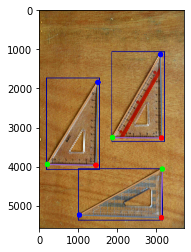

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(img_bgr[:,:,::-1])
plt.show()

In [25]:
cv2.imwrite('outputs/G3_opencv.jpg', img_bgr)

False